### Radius ~ r 

In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def scatter_density_vs_radius_3D(rho_field, R0, grid_spacing, sample_fraction=1.0):
    """
    Plot rho_field as a scatter plot against radius r (3D only).

    Parameters
    ----------
    rho_field : np.ndarray
        The 3D density field (shape: [Nz, Ny, Nx]).
    R0 : tuple of floats
        The reference point (x0, y0, z0) in grid indices.
    grid_spacing : tuple of floats
        Physical size of one grid cell (dx, dy, dz).
    sample_fraction : float
        Fraction of points to randomly sample for plotting.
    """
    # Grid shape
    Nz, Ny, Nx = rho_field.shape
    # Create 3D grid of coordinates
    dz, dy, dx = grid_spacing
    z, y, x = np.indices((Nz, Ny, Nx))
    '''
    print(x[0, 0], y[0, 0], z[0, 0])  # Debugging: print first grid point
    [ 0  1  2 ... Nx], [0 0 0 0 ... 0], [0 0 0 0 ... 0]
    '''
    x_phys = x * dx
    y_phys = y * dy
    z_phys = z * dz
    # Compute radius relative to R0 (in physical units)
    x0, y0, z0 = R0
    x0 = 0.5 * x_phys.units
    y0 = 0.5 * y_phys.units
    z0 = 0.5 * z_phys.units
    r = np.sqrt(((x_phys - x0 )**2) + ((y_phys - y0 )**2) + ((z_phys - z0 )**2))
    # Flatten arrays
    r_flat = r.flatten()
    rho_flat = rho_field.flatten()
    # Optional: random sampling
    if sample_fraction < 1.0:
        N = len(r_flat)
        idx = np.random.choice(N, int(N * sample_fraction), replace=False)
        r_flat = r_flat[idx]
        rho_flat = rho_flat[idx]

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(r_flat, rho_flat, s=2, alpha=0.5, c=r_flat, cmap="viridis")
    plt.xlabel("Radius $r$ (relative to $R_0$)")
    plt.ylabel("Density $\\rho$")
    plt.title("3D Density Scatter Plot vs Radius")
    plt.colorbar(label="Radius $r$")
    plt.grid(True)
    plt.show()

### Function Units

When plotting the density as function of distance relative to center of mass, the fitting function is chosen as
$$\rho\left(r\right):=\rho_{\text{hi}} - \frac{\rho_{\text{hi}} - \rho_{\text{lo}}}{2}  \left[1 + \tanh\left(\frac{r - r_0}{W}\right)\right]$$
where $r_0$ denotes the droplet radius needed to fit. $\lim_{r\to 0}\rho=\rho_{\text{hi}}$, and $\lim_{r\to\infty}\rho=\rho_{\text{lo}}$.

$$\frac{d\rho}{dr}=-\frac{\rho_{\text{hi}}-\rho_{\text{lo}}}{2W}\frac{1}{\cosh^{2}\left(\frac{r-r_{0}}{W}\right)}$$

At $r=r_{0}$, slope is $-\frac{\rho_{\text{hi}}-\rho_{\text{lo}}}{2W}$, so the width is $\frac{\rho_{\text{hi}}-\rho_{\text{lo}}}{\frac{\rho_{\text{hi}}-\rho_{\text{lo}}}{2W}}=2W$. Given center of mass $\bm{r}_0$, we need to fit $\rho_{\text{hi}},\rho_{\text{lo}}$ and $W$.

In [2]:
def trapezoid_3d_weight(shape): 
    """
    Compute trapezoidal integration weights for a 3D grid.
    """
    nx, ny, nz = shape
    wt = np.ones(shape)
    # Apply trapezoidal weights along x-axis
    wt[0, :, :] *= 0.5
    wt[-1, :, :] *= 0.5
    # Apply trapezoidal weights along y-axis
    wt[:, 0, :] *= 0.5
    wt[:, -1, :] *= 0.5
    # Apply trapezoidal weights along z-axis
    wt[:, :, 0] *= 0.5
    wt[:, :, -1] *= 0.5
    return wt

def get_center_of_mass(rho_field, L, cell_centered=True):
    """
    Compute center of mass for a 3D density field using trapezoidal integration
    ----------
    rho_field : ndarray
        3D density field (shape: nx, ny, nz).
    L : tuple of float
        Physical dimensions of the domain (Lx, Ly, Lz).
    cell_centered : bool
        If True, grid is cell based; else node based.
    Returns
    -------
    vec_com : numpy.ndarray
        Center of mass [x_cm, y_cm, z_cm].
    """
    nx, ny, nz = rho_field.shape
    if cell_centered:
        dx, dy, dz = L[0] / nx, L[1] / ny, L[2] / nz
        x = (np.arange(nx) + 0.5) * dx
        y = (np.arange(ny) + 0.5) * dy
        z = (np.arange(nz) + 0.5) * dz
    else:  # node-centered
        dx, dy, dz = L[0] / (nx - 1), L[1] / (ny - 1), L[2] / (nz - 1)
        x = np.arange(nx) * dx
        y = np.arange(ny) * dy
        z = np.arange(nz) * dz

    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # Compute trapezoidal weights
    wt = trapezoid_3d_weight(rho_field.shape)

    # Total mass (weighted integral of density)
    mass = np.sum(rho_field * wt * dx * dy * dz)

    # Weighted coordinate integrals
    x_cm = np.sum(X * rho_field * wt * dx * dy * dz) / mass
    y_cm = np.sum(Y * rho_field * wt * dx * dy * dz) / mass
    z_cm = np.sum(Z * rho_field * wt * dx * dy * dz) / mass

    return np.array([x_cm, y_cm, z_cm])

def read_frame_density(file_path):
    ts = yt.load(file_path)
    profile_data = ts.covering_grid(
        level=0, left_edge=ts.domain_left_edge, dims=ts.domain_dimensions
    )
    profile = profile_data['boxlib', 'rho']
    # grid lattice length
    box  = ts.domain_dimensions
    L = ts.domain_right_edge - ts.domain_left_edge
    dr = L/box
    return profile, L, box, dr

def func_density_dist(rho_field, L, r0=None):
    """
    Flatten the 3D density field into a 1D array and compute the relative distance from the center.
    ----------
    rho_field : np.ndarray
        The 3D density field (shape: [Nz, Ny, Nx]).
    L : tuple of float
        Physical dimensions of the domain (Lx, Ly, Lz), used to convert from dimensionless to physical units.
    Returns
    -------
    np.ndarray
        Flattened 1D array of the density field & relative distance from the center.
    """
    if r0 is None:
        r0 = get_center_of_mass(rho_field, L)
    Nz, Ny, Nx = rho_field.shape
    # Create 3D grid of coordinates
    dx, dy, dz = L[0] / Nx, L[1] / Ny, L[2] / Nz
    x = (np.arange(Nx) + 0.5) * dx
    y = (np.arange(Ny) + 0.5) * dy
    z = (np.arange(Nz) + 0.5) * dz
    r0 *= dx.units  # Convert from dimensionless to physical units !
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    r = np.sqrt(((X - r0[0])**2) + ((Y - r0[1])**2) + ((Z - r0[2])**2))
    return rho_field.flatten(), r.flatten()

def fit_droplet_radius(rho_field, L, r0):
    """
    Fit droplet radius, width & max/min density by using a tanh function. See above.
    Returns: (rho_hi_fit, rho_lo_fit, radius_fit, W_fit) tuples
    """
    # Define the fitting function
    def tanh_profile(r, rho_hi, rho_lo, radius, W):
        return rho_hi - (rho_hi - rho_lo)/2 * (1 + np.tanh((r - radius)/W))

    rho_field_flatten, r = func_density_dist(rho_field, L, r0)
    # Fit the density profile to the tanh function
    popt, _ = curve_fit(tanh_profile, r, rho_field_flatten, p0=[rho_field_flatten.max(), rho_field_flatten.min(), 0.5, 0.5])
    rho_hi_fit, rho_lo_fit, radius_fit, W_fit = popt
    return rho_hi_fit, rho_lo_fit, radius_fit, W_fit

def density_PCA_matrix(rho_field, L, cell_centered=True):
    """
    Assemble the covariance matrix for the 3D density field --- principal component analysis (PCA) of the mass distribution
    """
    nx, ny, nz = rho_field.shape
    if cell_centered:
        dx, dy, dz = L[0] / nx, L[1] / ny, L[2] / nz
        x = (np.arange(nx) + 0.5) * dx
        y = (np.arange(ny) + 0.5) * dy
        z = (np.arange(nz) + 0.5) * dz
    else:  # node-centered
        dx, dy, dz = L[0] / (nx - 1), L[1] / (ny - 1), L[2] / (nz - 1)
        x = np.arange(nx) * dx
        y = np.arange(ny) * dy
        z = np.arange(nz) * dz

    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    r0 = get_center_of_mass(rho_field, L, cell_centered)*dx.units
    # Compute trapezoidal weights
    wt = trapezoid_3d_weight(rho_field.shape)

    # Total mass (weighted integral of density)
    mass = np.sum(rho_field * wt * dx * dy * dz)

    # Weighted coordinate integrals
    C_XX = np.sum((X-r0[0])*(X-r0[0]) * rho_field * wt * dx * dy * dz) / mass
    C_YY = np.sum((Y-r0[1])*(Y-r0[1]) * rho_field * wt * dx * dy * dz) / mass
    C_ZZ = np.sum((Z-r0[2])*(Z-r0[2]) * rho_field * wt * dx * dy * dz) / mass
    C_XY = np.sum((X-r0[0])*(Y-r0[1]) * rho_field * wt * dx * dy * dz) / mass
    C_YZ = np.sum((Y-r0[1])*(Z-r0[2]) * rho_field * wt * dx * dy * dz) / mass
    C_ZX = np.sum((Z-r0[2])*(X-r0[0]) * rho_field * wt * dx * dy * dz) / mass

    return np.array([[C_XX, C_XY, C_ZX],
              [C_XY, C_YY, C_YZ],
              [C_ZX, C_YZ, C_ZZ]])

def principal_axes(rho_field, L, radius, cell_centered=True):
    mat_C = density_PCA_matrix(rho_field, L, cell_centered)
    eigenvalues, eigenvectors = np.linalg.eig(mat_C)
    a = eigenvalues[0]**(1./3.)*radius/((eigenvalues[1]*eigenvalues[2])**(1./6.))
    b = eigenvalues[1]**(1./3.)*radius/((eigenvalues[0]*eigenvalues[2])**(1./6.))
    c = eigenvalues[2]**(1./3.)*radius/((eigenvalues[0]*eigenvalues[1])**(1./6.))
    return np.array([a, b, c]), eigenvalues, eigenvectors

### Plot single trajectory frame (droplet system): density $\rho\left(r\right)$ ~ relative distance to center-of-mass $r$

yt : [INFO     ] 2025-07-28 04:34:47,405 Parameters: current_time              = 820000.0
yt : [INFO     ] 2025-07-28 04:34:47,406 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-07-28 04:34:47,407 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-28 04:34:47,408 Parameters: domain_right_edge         = [1. 1. 1.]


Center of Mass: [0.51488052 0.51241728 0.5135624 ]
Fitted Droplet Radius: 0.23111855337459344
Eigenvalues: [0.01548751 0.01543184 0.01543958]
Eigenvectors:
 [[-0.5775583  -0.5875318  -0.56677402]
 [-0.68515398  0.7263378  -0.05474878]
 [-0.44383604 -0.35670686  0.82205218]]
Principal Axes (a, b, c): [0.23137677 0.2309606  0.23101851]
Residue Error for eigenvectors is (norm_p=2): 1.792141588980684e-17


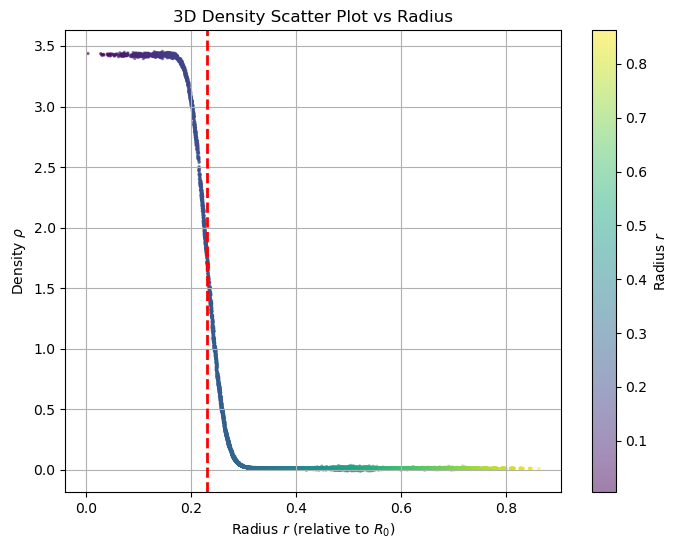

In [5]:
alpha0 = 1.5
temperature = 1e-5 #0.
frameIdx = 820000
r0 = 0.25
nx = 32
ny = 32
nz = 32
if temperature == 0.:
    file_path = "./data_droplet_alpha0_{:.2f}_r{:.2f}_size{:d}-{:d}-{:d}/lbm_data_shshan_alpha0_".format(alpha0, r0, nx, ny, nz) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}/".format(nx, ny, nz) + "plt" + f"{frameIdx:07d}"
else:
    file_path = "./data_droplet_alpha0_{:.2f}_r{:.2f}_size{:d}-{:d}-{:d}/lbm_data_shshan_alpha0_".format(alpha0, r0, nx, ny, nz) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}_continue/".format(nx, ny, nz) + "plt" + f"{frameIdx:07d}"

rho_field, L, box, dr = read_frame_density(file_path)
rho_flat, r_flat = func_density_dist(rho_field, L)
r0 = get_center_of_mass(rho_field, L)
print("Center of Mass:", r0)
rho_hi, rho_lo, R, W = fit_droplet_radius(rho_field, L, r0)
print("Fitted Droplet Radius:", R)
mat_C = density_PCA_matrix(rho_field, L)
pca_axes, eigenvalues, eigenvectors = principal_axes(rho_field, L, R)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:\n", eigenvectors)
print("Principal Axes (a, b, c):", pca_axes)
residue_error = np.linalg.norm(mat_C @ eigenvectors[:, 0] - eigenvalues[0] * eigenvectors[:, 0], ord=2) + \
    np.linalg.norm(mat_C @ eigenvectors[:, 1] - eigenvalues[1] * eigenvectors[:, 1], ord=2) + \
    np.linalg.norm(mat_C @ eigenvectors[:, 2] - eigenvalues[2] * eigenvectors[:, 2], ord=2)
print("Residue Error for eigenvectors is (norm_p=2):", residue_error)

#print(rho_field.shape, box, dr)
#scatter_density_vs_radius_3D(rho_field, R0=(0.5, 0.5, 0.5), grid_spacing=(dr[0], dr[1], dr[2]))
plt.figure(figsize=(8, 6))
plt.scatter(r_flat, rho_flat, s=2, alpha=0.5, c=r_flat, cmap="viridis")
plt.axvline(x=R, color="red", linestyle="--", linewidth=2, label=f"$R={R}$")
plt.xlabel("Radius $r$ (relative to $R_0$)")
plt.ylabel("Density $\\rho$")
plt.title("3D Density Scatter Plot vs Radius")
plt.colorbar(label="Radius $r$")
plt.grid(True)
plt.show()

#### Density evolution -- Mass Conservation

Trajectories segments: box size $\left(32,32,32\right)$

##### $\text{temperature}=10^{-5}$
$$420000\ ~\ 820000,\ \text{plot\_int}=500$$
$$1220000\ ~\ 1620000,\ \text{plot\_int}=500$$
$$1820000\ ~\ 2020000,\ \text{plot\_int}=200$$

##### $\text{temperature}=10^{-4}$
$$1620000\ ~\ 1820000,\ \text{plot\_int}=200$$



yt : [INFO     ] 2025-08-01 06:34:44,581 Parameters: current_time              = 1620000.0
yt : [INFO     ] 2025-08-01 06:34:44,582 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-01 06:34:44,582 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-01 06:34:44,583 Parameters: domain_right_edge         = [1. 1. 1.]


Processing frames from 1620000 to 1820000 with interval 200, total 1001 frames...


yt : [INFO     ] 2025-08-01 06:34:44,693 Parameters: current_time              = 1620200.0
yt : [INFO     ] 2025-08-01 06:34:44,693 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-01 06:34:44,694 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-01 06:34:44,695 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-01 06:34:44,834 Parameters: current_time              = 1620400.0
yt : [INFO     ] 2025-08-01 06:34:44,835 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-01 06:34:44,836 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-01 06:34:44,838 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-01 06:34:45,093 Parameters: current_time              = 1620600.0
yt : [INFO     ] 2025-08-01 06:34:45,094 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-01 06:34:45,095 Parameters: domain_left_edge          = [0

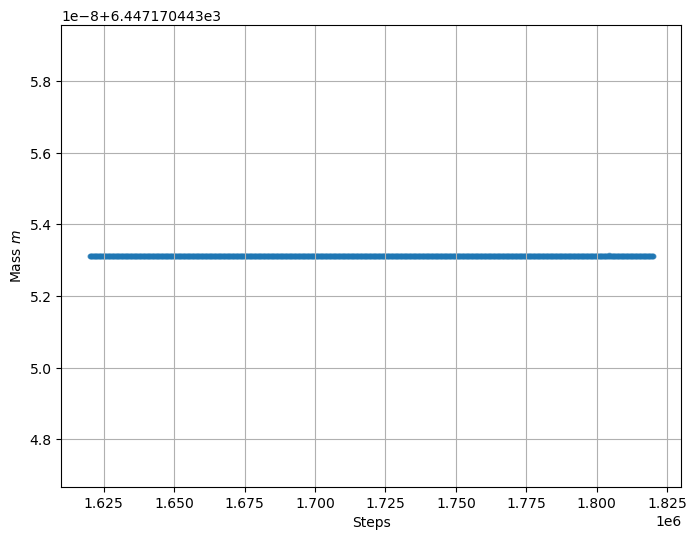

In [5]:
alpha0 = 1.5
temperature = 1e-4 #1e-5 #0.
frame1 = 1620000 #420000 #420000 #1220000
frame2 = 1820000 #820000 #820000 #1620000
plot_int = 200
N = (frame2 - frame1) // plot_int + 1
r_init = 0.25
nx = 32 #64
ny = 32 #64
nz = 32 #64

step_array = range(frame1, frame2+1, plot_int)
mass_array = np.zeros(N)
r0_array = np.zeros((N, 3))
r0_init = np.zeros(3)

print(f"Processing frames from {frame1} to {frame2} with interval {plot_int}, total {N} frames...")
# Loop through frames and compute instantaneous R(t) & principal axes a(t), b(t), c(t)
for n in range(N):
    frameIdx = frame1 + n*plot_int
    file_path = "./data_droplet_alpha0_{:.2f}_r{:.2f}_size{:d}-{:d}-{:d}/lbm_data_shshan_alpha0_".format(alpha0, r_init, nx, ny, nz) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}_continue/".format(nx, ny, nz) + "plt" + f"{frameIdx:07d}"
    rho_field, L, box, dr = read_frame_density(file_path)
    vec_r0 = get_center_of_mass(rho_field, L)
    if n == 0:
        r0_init = vec_r0
    mass_array[n] = np.sum(rho_field)
    r0_array[n, :] = vec_r0 - r0_init

plt.figure(figsize=(8, 6))
plt.scatter(step_array, mass_array, s=10, alpha=0.5)
plt.xlabel("Steps")
plt.ylabel("Mass $m$")
plt.grid(True)
plt.show()

#### Plot center-of-mass trajectories

Processing frames from 1620000 to 1820000 with interval 200, total 1001 frames...


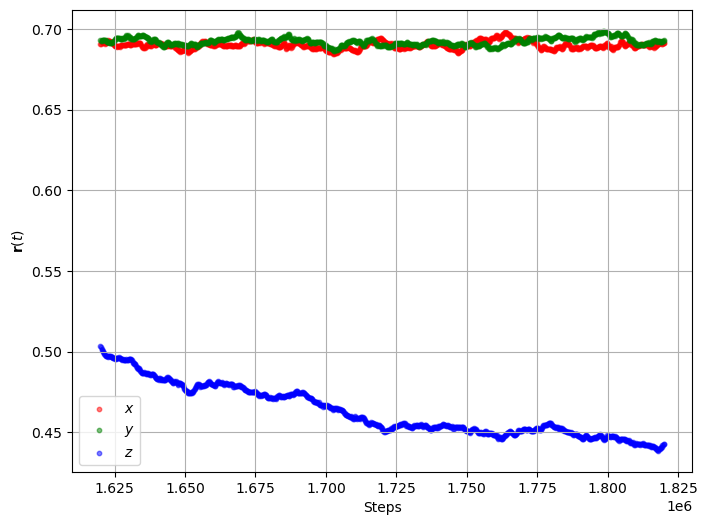

In [19]:
print(f"Processing frames from {frame1} to {frame2} with interval {plot_int}, total {N} frames...")

plt.figure(figsize=(8, 6))
plt.scatter(step_array, r0_array[:, 0] + r0_init[0], s=10, alpha=0.5, c='red', label=r'$x$')
plt.scatter(step_array, r0_array[:, 1] + r0_init[1], s=10, alpha=0.5, c='green', label=r'$y$')
plt.scatter(step_array, r0_array[:, 2] + r0_init[2], s=10, alpha=0.5, c='blue', label=r'$z$')
plt.xlabel("Steps")
plt.ylabel(r"$\mathbf{r}(t)$")
plt.legend()
plt.grid(True)
plt.show()

#### Plot center-of-mass displacement ~ steps

$$\left|\bm{r}\left(t\right)-\bm{r}_{0}\left(0\right)\right|\sim t$$

Processing frames from 1620000 to 1820000 with interval 200, total 1001 frames...


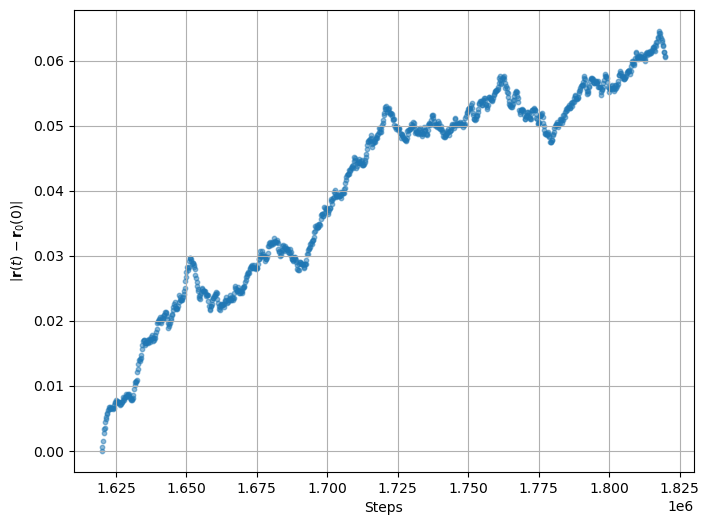

In [6]:
print(f"Processing frames from {frame1} to {frame2} with interval {plot_int}, total {N} frames...")

plt.figure(figsize=(8, 6))
plt.scatter(step_array, np.sqrt(np.sum(r0_array**2, axis=1)), s=10, alpha=0.5)
plt.xlabel("Steps")
plt.ylabel(r"$\left|\mathbf{r}(t) - \mathbf{r}_{0}(0)\right|$")
plt.grid(True)
plt.show()

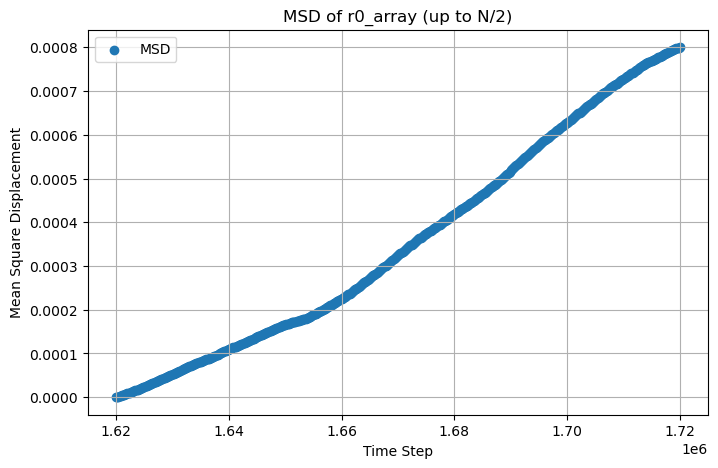

In [7]:
# Compute MSD
def compute_msd(r):
    N = r.shape[0]
    max_num_samples = N // 2
    num_samples = max_num_samples 
    msd = np.zeros(num_samples)
    for n in range(1, num_samples+1):
        diff = r[n:] - r[:-n]
        #print(diff.shape)
        msd[n-1] = np.mean(np.sum(diff[0:num_samples, :]**2, axis=1))
    return msd, num_samples

msd, num_samples = compute_msd(r0_array[0:6000])
# Insert MSD=0 at dt=0
msd = np.insert(msd, 0, 0.0)

plt.figure(figsize=(8, 5))
plt.scatter(range(frame1, frame1+num_samples*plot_int+1, plot_int), msd, label='MSD')
plt.xlabel('Time Step')
plt.ylabel('Mean Square Displacement')
plt.title('MSD of r0_array (up to N/2)')
plt.legend()
plt.grid(True)
plt.show()

### Loop through frames and compute instantaneous $R(t)$ & principal axes $a(t), b(t), c(t)$

In [8]:
#alpha0 = 1.5
#temperature = 1e-5 #0.
#plot_int = 500
#N = (frame2 - frame1) // plot_int + 1
#r_init = 0.25
#nx = 32
#ny = 32
#nz = 32

R_array = np.zeros(N)
a_array = np.zeros(N)
b_array = np.zeros(N)
c_array = np.zeros(N)

print(f"Processing frames from {frame1} to {frame2} with interval {plot_int}, total {N} frames...")
# Loop through frames and compute instantaneous R(t) & principal axes a(t), b(t), c(t)
for n in range(N):
    frameIdx = frame1 + n*plot_int
    file_path = "./data_droplet_alpha0_{:.2f}_r{:.2f}_size{:d}-{:d}-{:d}/lbm_data_shshan_alpha0_".format(alpha0, r_init, nx, ny, nz) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}_continue/".format(nx, ny, nz) + "plt" + f"{frameIdx:07d}"
    
    rho_field, L, box, dr = read_frame_density(file_path)
    r0 = get_center_of_mass(rho_field, L)
    rho_hi, rho_lo, R, W = fit_droplet_radius(rho_field, L, r0)
    pca_axes, eigenvalues, eigenvectors = principal_axes(rho_field, L, R)

    R_array[n] = R
    a_array[n] = pca_axes[0]
    b_array[n] = pca_axes[1]
    c_array[n] = pca_axes[2]

yt : [INFO     ] 2025-08-01 06:42:42,488 Parameters: current_time              = 1620000.0
yt : [INFO     ] 2025-08-01 06:42:42,489 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-01 06:42:42,490 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-01 06:42:42,491 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-01 06:42:42,633 Parameters: current_time              = 1620200.0
yt : [INFO     ] 2025-08-01 06:42:42,633 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-01 06:42:42,634 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-01 06:42:42,635 Parameters: domain_right_edge         = [1. 1. 1.]


Processing frames from 1620000 to 1820000 with interval 200, total 1001 frames...


yt : [INFO     ] 2025-08-01 06:42:42,773 Parameters: current_time              = 1620400.0
yt : [INFO     ] 2025-08-01 06:42:42,774 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-01 06:42:42,775 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-01 06:42:42,775 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-01 06:42:42,960 Parameters: current_time              = 1620600.0
yt : [INFO     ] 2025-08-01 06:42:42,961 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-01 06:42:42,962 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-01 06:42:42,963 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-01 06:42:43,131 Parameters: current_time              = 1620800.0
yt : [INFO     ] 2025-08-01 06:42:43,132 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-08-01 06:42:43,133 Parameters: domain_left_edge          = [0

#### Ensemble average for $\sum_{i=1}^{2}\sum_{j=i+1}^{3}\left\langle \left[\delta a_{i}\left(t\right)+\delta a_{j}\left(t\right)\right]^{2}\right\rangle $ and $\sum_{i=1}^{2}\sum_{j=i+1}^{3}\left\langle \left[\delta a_{i}\left(t\right)-\delta a_{j}\left(t\right)\right]^{2}\right\rangle $

In [10]:
delta_a_array = a_array - R_array
delta_b_array = b_array - R_array
delta_c_array = c_array - R_array

t_window = 100000
N_win = (frame2-t_window-frame1)//plot_int
print("number of frames per observation window is:", N_win)
corvariance_plus = np.zeros(N_win)
corvariance_minus = np.zeros(N_win)

for n in range(frame1, frame2-t_window, plot_int):
    win_idx = (n-frame1)//plot_int
    corvariance_plus[win_idx] = np.mean((delta_a_array[win_idx:(win_idx + N_win)] + delta_b_array[win_idx:(win_idx + N_win)])**2 +\
                                (delta_a_array[win_idx:(win_idx + N_win)] + delta_c_array[win_idx:(win_idx + N_win)])**2 +\
                                      (delta_b_array[win_idx:(win_idx + N_win)] + delta_c_array[win_idx:(win_idx + N_win)])**2)
    corvariance_minus[win_idx] = np.mean((delta_a_array[win_idx:(win_idx + N_win)] - delta_b_array[win_idx:(win_idx + N_win)])**2 +\
                                 (delta_a_array[win_idx:(win_idx + N_win)] - delta_c_array[win_idx:(win_idx + N_win)])**2 +\
                                      (delta_b_array[win_idx:(win_idx + N_win)] - delta_c_array[win_idx:(win_idx + N_win)])**2)

    corvariance_plus[win_idx] = corvariance_plus[win_idx]/(dr[0]**2.)
    corvariance_minus[win_idx] = corvariance_minus[win_idx]/(dr[0]**2.)


number of frames per observation window is: 500


#### Surface Tension
$$\gamma_{\left(2,0\right)}=\frac{15k_{B}T}{16\pi\sum_{i=1}^{2}\sum_{j=i+1}^{3}\left\langle \left[\delta a_{i}\left(t\right)+\delta a_{j}\left(t\right)\right]^{2}\right\rangle },\ \ \ \gamma_{\left(2,\pm2\right)}=\frac{45k_{B}T}{16\pi\sum_{i=1}^{2}\sum_{j=i+1}^{3}\left\langle \left[\delta a_{i}\left(t\right)-\delta a_{j}\left(t\right)\right]^{2}\right\rangle }$$

<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_473352/794622041.py:8: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$\gamma$")


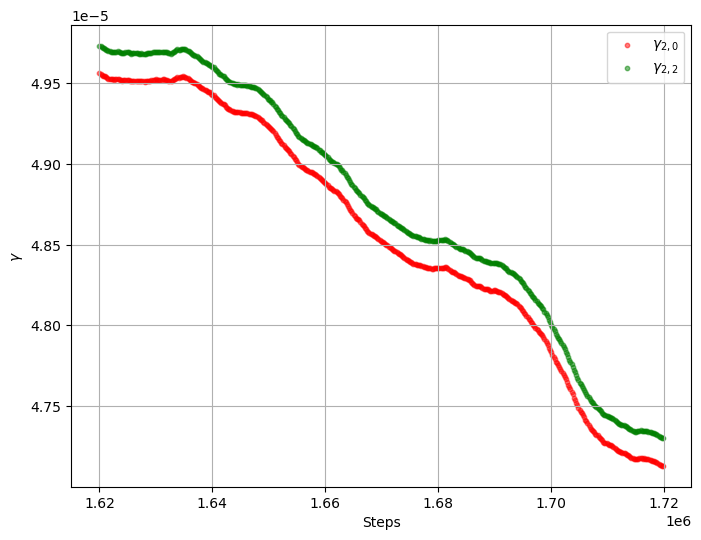

0.040481044658283144 1/code_length
0.6539091059464588 1/code_length
0.30783158251309667 1/code_length
0.305596478775079 1/code_length


In [12]:
gamma_2_0 = 15.*temperature/(16.*np.pi*corvariance_plus)
gamma_2_2 = 45.*temperature/(16.*np.pi*corvariance_minus)

plt.figure(figsize=(8, 6))
plt.scatter(range(frame1, frame2-t_window, plot_int), gamma_2_0, s=10, alpha=0.5, c='red', label=r'$\gamma_{2,0}$')
plt.scatter(range(frame1, frame2-t_window, plot_int), gamma_2_2, s=10, alpha=0.5, c='green', label=r'$\gamma_{2,2}$')
plt.xlabel("Steps")
plt.ylabel("$\gamma$")
plt.legend()
plt.grid(True)
plt.show()

print(np.mean(np.abs(delta_a_array + delta_b_array + delta_c_array))/dr[0])
print(np.mean(np.abs(delta_a_array))/dr[0])
print(np.mean(np.abs(delta_b_array))/dr[0])
print(np.mean(np.abs(delta_c_array))/dr[0])

size-32-32-32
frame1 = 1220000
frame2 = 1620000
2.471046124556462e-06 1/code_length
0.004532194654529034 1/code_length

frame1 = 420000
frame2 = 820000
3.842681673557852e-06 1/code_length
0.005783613525256861 1/code_length
0.002976382368320943 1/code_length
0.0028240120115155046 1/code_length

size-64-64-64
1.212882521169698e-06 1/code_length
0.004583951121207923 1/code_length
0.0023734380471268305 1/code_length
0.0022523934738637847 1/code_length